# Digit Recognizer

In this notebook we attempt to classify digits using a convolutive neural network. Data taken from the digit-recognizer dataset on Kaggle.

In [55]:
'''Reset variables, when needed'''
#%reset

'Reset variables, when needed'

In [56]:
'''Imports'''
import numpy as np
import matplotlib.pyplot as plt
import csv
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from tensorflow.python import keras
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense, Flatten, Conv2D, Dropout, MaxPool2D
import seaborn as sns
import itertools

%matplotlib inline

# Tensorflow-gpu? Faster with GTX?

sns.set(style='white', context='notebook', palette='deep')

'''Constants'''
img_rows = 28
img_cols = 28
num_classes = 10
random_seed = 8

# Model parameters
n_filters1 = 32
n_filters2 = 64
kernel_size1 = (5,5)
kernel_size2 = (3,3)
activ = 'relu'       
final_activ = 'softmax'
inp_shape = (img_rows, img_cols, 1)
n_neurons = 256
drop_prob1 = 0.25
drop_prob2 = 0.5
test_size = 0.1
padding = 'Same'

# Compiler parameters
loss = keras.losses.categorical_crossentropy
metrics = ['accuracy']

# Fitting parameters
batch_size = 86
epochs = 30 # Turn to 30 later


'''Load dataset'''
data_directory = 'C:\\Users\\David Montgomery\\.kaggle\\competitions\\digit-recognizer\\'

train_directory = data_directory + "train.csv"
test_directory = data_directory + "test.csv"

train_df = pd.read_csv(train_directory)
test_df = pd.read_csv(test_directory)

train_df = train_df.dropna(axis=0)

In [57]:
# View the loaded data
train_df.describe()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
count,42000.000000,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,...,42000.000000,42000.000000,42000.000000,42000.00000,42000.000000,42000.000000,42000.0,42000.0,42000.0,42000.0
mean,4.456643,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.219286,0.117095,0.059024,0.02019,0.017238,0.002857,0.0,0.0,0.0,0.0
std,2.887730,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,6.312890,4.633819,3.274488,1.75987,1.894498,0.414264,0.0,0.0,0.0,0.0
min,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0
25%,2.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0
50%,4.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0
75%,7.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0
max,9.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,254.000000,254.000000,253.000000,253.00000,254.000000,62.000000,0.0,0.0,0.0,0.0


1    4684
7    4401
3    4351
9    4188
2    4177
6    4137
0    4132
4    4072
8    4063
5    3795
Name: label, dtype: int64

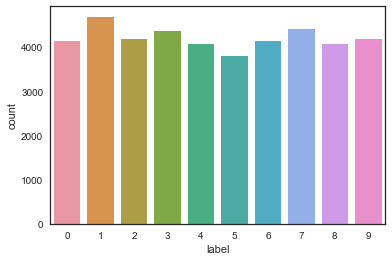

In [58]:
'''Data preparation'''
y_df = train_df["label"]
X_df = train_df.drop(labels = ["label"], axis=1)

# Have a look at balance of training data
g = sns.countplot(y_df)
y_df.value_counts()

In [59]:
'''Check for null and missing values'''
X_df.isnull().any().describe()

count       784
unique        1
top       False
freq        784
dtype: object

In [60]:
test_df.isnull().any().describe()

count       784
unique        1
top       False
freq        784
dtype: object

In [61]:
'''Data preparation'''
X_df = X_df/255.0
test_df = test_df/255.0

X = X_df.values.reshape(-1, 28, 28, 1)          # -1 for unknown form
test_X = test_df.values.reshape(-1, 28, 28, 1)

y = keras.utils.to_categorical(y_df, num_classes=num_classes)

# Split data into train and validation set
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=test_size,
                                                 random_state=random_seed)

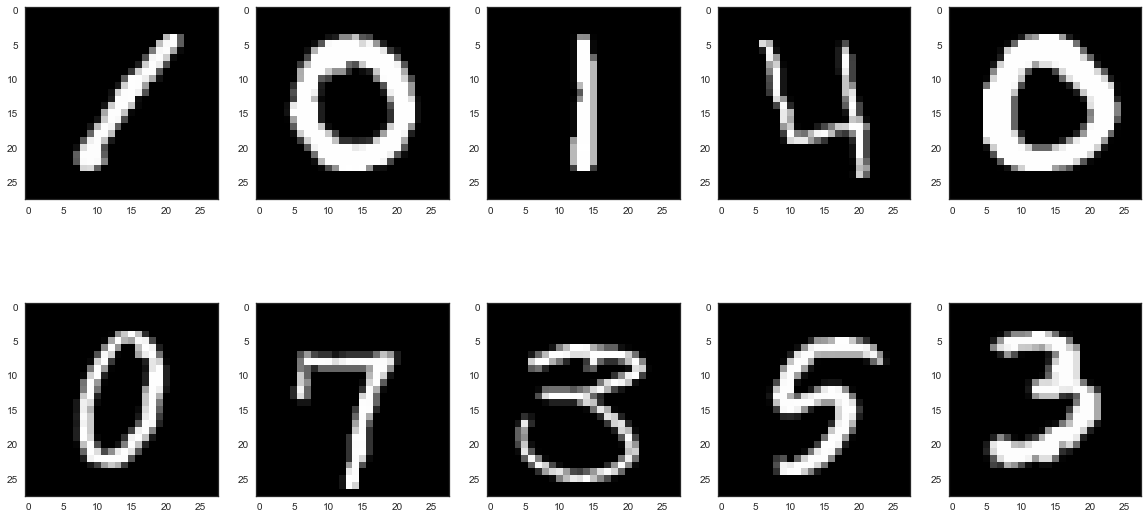

In [62]:
'''View first 10 digits'''
plt.figure(figsize=(20,10))
for i in range(10):
    row = X[i,:]
    row = np.reshape(row, [img_rows, img_cols])
    plt.subplot(2, 5, i+1)
    plt.imshow(row, cmap='gray')

In [63]:
'''Create model'''
digit_model = Sequential()
digit_model.add(Conv2D(filters = n_filters1,
                      kernel_size = kernel_size1,
                      activation = activ,
                      padding = padding,
                      input_shape = inp_shape))
digit_model.add(Conv2D(filters = n_filters1,
                      kernel_size = kernel_size1,
                      padding = padding,
                      activation = activ))
digit_model.add(MaxPool2D(pool_size = (2,2)))
digit_model.add(Dropout(drop_prob1))

digit_model.add(Conv2D(filters = n_filters2,
                      kernel_size = kernel_size2,
                      padding = padding,
                      activation = activ))
digit_model.add(Conv2D(filters = n_filters2,
                      kernel_size = kernel_size2,
                      padding = padding,
                      activation = activ))
digit_model.add(MaxPool2D(pool_size = (2,2)))
digit_model.add(Dropout(drop_prob1))

digit_model.add(Flatten())
digit_model.add(Dense(n_neurons,
                     activation = activ))
digit_model.add(Dropout(drop_prob2))
digit_model.add(Dense(num_classes,
                     activation = final_activ))

'''Set model optimizer and annealer'''
optimizer = keras.optimizers.RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)

'''Compile model'''
digit_model.compile(loss = loss, optimizer = optimizer, metrics = metrics)

In [64]:
'''Data augmentation'''
learning_rate_reducer = keras.callbacks.ReduceLROnPlateau(monitor='val_acc',
                                                         patience=3,
                                                         verbose=1,
                                                         factor=0.5,
                                                         min_lr=0.00001)

datagen = keras.preprocessing.image.ImageDataGenerator(
                featurewise_center = False,
                samplewise_center = False,
                featurewise_std_normalization = False,
                samplewise_std_normalization = False,
                zca_whitening = False,
                rotation_range = 10,
                zoom_range = 0.1, 
                width_shift_range = 0.1,
                height_shift_range = 0.1,
                horizontal_flip = False,
                vertical_flip = False)

datagen.fit(X_train)

In [65]:
'''Model fitting'''
history = digit_model.fit_generator(datagen.flow(X_train, 
                                       y_train, 
                                       batch_size = batch_size), 
                                       epochs = epochs,
                                       validation_data = (X_val, y_val),
                                       steps_per_epoch = X_train.shape[0]//batch_size,
                                       callbacks = [learning_rate_reducer])

Epoch 1/30
439/439 [==============================] - 264s 601ms/step - loss: 0.4167 - acc: 0.8679 - val_loss: 0.0593 - val_acc: 0.9819
Epoch 2/30
439/439 [==============================] - 261s 595ms/step - loss: 0.1277 - acc: 0.9616 - val_loss: 0.0417 - val_acc: 0.9852
Epoch 3/30
439/439 [==============================] - 262s 597ms/step - loss: 0.0919 - acc: 0.9729 - val_loss: 0.0385 - val_acc: 0.9864
Epoch 4/30
439/439 [==============================] - 261s 594ms/step - loss: 0.0795 - acc: 0.9766 - val_loss: 0.0302 - val_acc: 0.9902
Epoch 5/30
439/439 [==============================] - 262s 597ms/step - loss: 0.0675 - acc: 0.9807 - val_loss: 0.0271 - val_acc: 0.9921
Epoch 6/30
439/439 [==============================] - 261s 596ms/step - loss: 0.0642 - acc: 0.9815 - val_loss: 0.0276 - val_acc: 0.9924
Epoch 7/30
439/439 [==============================] - 262s 596ms/step - loss: 0.0615 - acc: 0.9825 - val_loss: 0.0281 - val_acc: 0.9898
Epoch 8/30
439/439 [============================

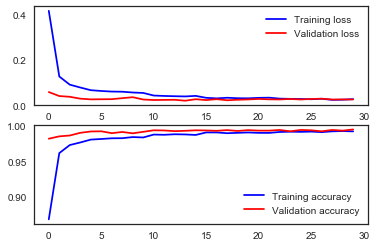

In [66]:
'''Model evaluation'''
fig, ax = plt.subplots(2, 1)
ax[0].plot(history.history['loss'], color = 'b', label = 'Training loss')
ax[0].plot(history.history['val_loss'], color = 'r', label = 'Validation loss',
            axes = ax[0])
legend = ax[0].legend(loc = 'best', shadow = True)

ax[1].plot(history.history['acc'], color = 'b', label = 'Training accuracy')
ax[1].plot(history.history['val_acc'], color = 'r', label='Validation accuracy')
legend = ax[1].legend(loc = 'best', shadow = True)

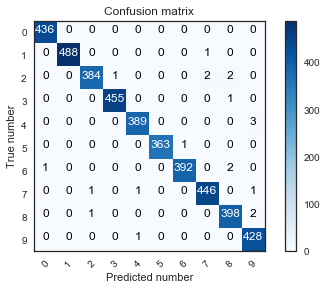

In [67]:
'''Confusion matrix'''

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    if normalize:
        cm = cm.astype('float')/cm.sum(axis=1)[:, np.newaxis]
    
    thresh = cm.max()/2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i,j], 
                horizontalalignment='center',
                color='white' if cm[i,j] > thresh else 'black')
    plt.tight_layout()
    plt.ylabel('True number')
    plt.xlabel('Predicted number')
    
y_pred = digit_model.predict(X_val)
y_pred_one_hot = np.argmax(y_pred, axis=1)
y_val_one_hot = np.argmax(y_val, axis=1)
cf_matrix = confusion_matrix(y_val_one_hot, y_pred_one_hot)
plot_confusion_matrix(cf_matrix, classes = range(10))


## Test set
Now that we have a somewhat decent model we continue to predict on the test set


In [68]:
'''Data preparation'''
data = test_df.as_matrix()
X = data
num_of_images = X.shape[0]
X_out = X.reshape(num_of_images, img_rows, img_cols, 1)
X_out = X_out/255

'''Generate predictions'''
y_hat = digit_model.predict(X_out)

# Select inde with maximum probability
results = np.argmax(y_hat, axis=1)
results = pd.Series(results, name="Label")

In [69]:
# Write to csv
submission = pd.concat([pd.Series(range(1, 28001), name='ImageId'), results], axis=1)
submission.to_csv("my_submission.csv", index=False)